In [12]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, classification_report, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve
import warnings
import os

warnings.filterwarnings('ignore')
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

# Klasyfikacja ryzyka cukrzycy na podstawie wskaźników zdrowotnych

## Autorzy
- Filip Obuchowicz   s223421
- Kamil Pizon        s223434

## Streszczenie
Projekt ma na celu budowę i porównanie modeli klasyfikacyjnych do przewidywania ryzyka cukrzycy na danych BRFSS2015. Przeprowadzono wstępną analizę danych, transformacje (logarytmowanie, skalowanie) oraz zastosowano SMOTE do zbalansowania klas. Porównano modele KNN, Drzewo Decyzyjne, Las Losowy oraz model hybrydowy, oceniając je metrykami Accuracy, F1-Score i AUC. Stabilność zbadano walidacją krzyżową. Zaprezentowano użycie modeli na sztucznych obserwacjach.

## Słowa kluczowe
- **Cukrzyca:** Choroba metaboliczna, przedmiot predykcji.
- **Klasyfikacja:** Zadanie uczenia maszynowego (przypisanie do klas ryzyka cukrzycy).
- **Uczenie Maszynowe:** Budowa modeli predykcyjnych z danych.
- **KNN:** Algorytm klasyfikujący na podstawie k najbliższych sąsiadów.
- **Drzewo Decyzyjne:** Model w postaci drzewa decyzji.
- **Las Losowy:** Zespół drzew decyzyjnych dla lepszej predykcji.
- **Model Hybrydowy:** Połączenie predykcji z wielu modeli.
- **Analiza Danych (EDA):** Badanie danych w celu zrozumienia ich cech.
- **SMOTE:** Technika nadpróbkowania klasy mniejszościowej.
- **Walidacja Krzyżowa:** Metoda oceny generalizacji modelu.


## Wprowadzenie
Cukrzyca to globalny problem zdrowotny. Wczesne wykrycie ryzyka jest kluczowe dla zapobiegania powikłaniom. Modele predykcyjne oparte na uczeniu maszynowym mogą pomóc w identyfikacji osób zagrożonych, umożliwiając wczesną interwencję. Projekt skupia się na zastosowaniu takich modeli na danych BRFSS, aby klasyfikować ryzyko cukrzycy.

## Przedmiot badania i Cel
**Przedmiot badania:** Dane `diabetes_012_health_indicators_BRFSS2015.csv` z badania BRFSS 2015, zawierające wskaźniki zdrowotne i demograficzne. Zmienna docelowa `Diabetes_012` (brak cukrzycy, stan przedcukrzycowy, cukrzyca) zostanie przekształcona na binarną: 0 (brak cukrzycy) vs 1 (stan przedcukrzycowy/cukrzyca).

**Cel:** Opracowanie, trening i ocena modeli klasyfikacyjnych do przewidywania binarnego ryzyka cukrzycy. Porównanie wydajności algorytmów KNN, Drzewa Decyzyjnego, Lasu Losowego i modelu hybrydowego. Identyfikacja kluczowych zmiennych oraz demonstracja działania modeli.

## Wstępna analiza danych

### 1. Opis danych i zmiennych
Dane BRFSS2015 (253,680 obserwacji, 22 zmienne). Zmienna `Diabetes_012` transformowana: 0 (brak cukrzycy), 1 (ryzyko: stan przedcukrzycowy/cukrzyca).

In [13]:
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
df['Diabetes_012'] = df['Diabetes_012'].replace({1: 1, 2: 1})
print("Pierwsze 5 wierszy danych:")
print(df.head())


Pierwsze 5 wierszy danych:
   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0

Wszystkie zmienne są numeryczne (float64). Mamy 21 zmiennych objaśniających:

* **Binarne (0/1):** `HighBP`, `HighChol`, `Smoker`, `PhysActivity`, `Sex` itp. (łącznie 14 zmiennych, np. `CholCheck`, `Stroke`, `HeartDiseaseorAttack`, `Fruits`, `Veggies`, `HvyAlcoholConsump`, `AnyHealthcare`, `NoDocbcCost`, `DiffWalk`).
* **Kategoryczne/Porządkowe:** `GenHlth` (ogólny stan zdrowia, 1-5), `MentHlth` (dni złego samopoczucia psychicznego, 0-30), `PhysHlth` (dni złego samopoczucia fizycznego, 0-30), `Age` (kategoria wiekowa, 1-13), `Education` (poziom edukacji, 1-6), `Income` (poziom dochodu, 1-8).
* **Ciągłe:** `BMI` (wskaźnik masy ciała).

### 2. Statystyki opisowe
Analiza podstawowych statystyk, w tym skośności, dla zrozumienia rozkładów zmiennych.

In [14]:
desc = df.describe().T
desc["skewness"] = df.skew()
print(desc[["mean", "50%", "min", "max", "std", "skewness"]].round(2))

                       mean   50%   min   max   std  skewness
Diabetes_012           0.16   0.0   0.0   1.0  0.36      1.88
HighBP                 0.43   0.0   0.0   1.0  0.49      0.29
HighChol               0.42   0.0   0.0   1.0  0.49      0.31
CholCheck              0.96   1.0   0.0   1.0  0.19     -4.88
BMI                   28.38  27.0  12.0  98.0  6.61      2.12
Smoker                 0.44   0.0   0.0   1.0  0.50      0.23
Stroke                 0.04   0.0   0.0   1.0  0.20      4.66
HeartDiseaseorAttack   0.09   0.0   0.0   1.0  0.29      2.78
PhysActivity           0.76   1.0   0.0   1.0  0.43     -1.20
Fruits                 0.63   1.0   0.0   1.0  0.48     -0.56
Veggies                0.81   1.0   0.0   1.0  0.39     -1.59
HvyAlcoholConsump      0.06   0.0   0.0   1.0  0.23      3.85
AnyHealthcare          0.95   1.0   0.0   1.0  0.22     -4.18
NoDocbcCost            0.08   0.0   0.0   1.0  0.28      3.00
GenHlth                2.51   2.0   1.0   5.0  1.07      0.42
MentHlth

**Interpretacja:** `Diabetes_012` ma średnią ~0.16 i skośność 1.88, wskazując na niezbalansowanie klas. `BMI`, `MentHlth`, `PhysHlth` są prawostronnie skośne (skośność >2), co sugeruje potrzebę transformacji. Wiele zmiennych binarnych ma małą skośność.

### 3. Podstawowa wizualizacja danych
Wizualizacje pomagają zrozumieć rozkłady poszczególnych zmiennych oraz zidentyfikować potencjalne relacje między zmiennymi objaśniającymi a zmienną docelową.

#### Rozkład zmiennej docelowej `Diabetes_012`

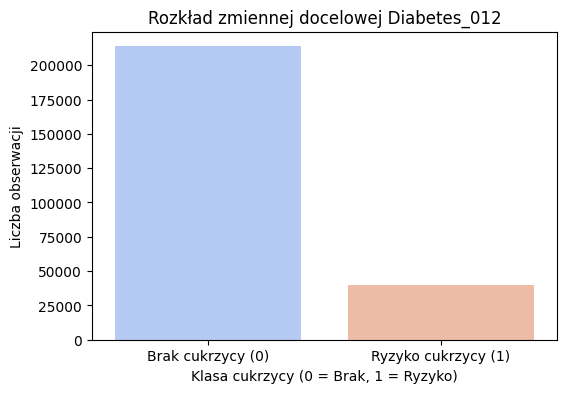

Diabetes_012
0.0    0.842
1.0    0.158
Name: proportion, dtype: float64


In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Diabetes_012', data=df, palette='coolwarm')
plt.title('Rozkład zmiennej docelowej Diabetes_012')
plt.xlabel('Klasa cukrzycy (0 = Brak, 1 = Ryzyko)')
plt.ylabel('Liczba obserwacji')
plt.xticks([0, 1], ['Brak cukrzycy (0)', 'Ryzyko cukrzycy (1)'])
plt.show()
print(df['Diabetes_012'].value_counts(normalize=True).round(3))

**Interpretacja:** Wykres potwierdza niezbalansowanie klas: ~84.2% to klasa '0' (brak cukrzycy), ~15.8% to klasa '1' (ryzyko). Uzasadnia to użycie SMOTE.

#### Histogramy dla zmiennych numerycznych i porządkowych
Poniżej znajdują się histogramy dla zmiennych, które nie są ściśle binarne, aby pokazać ich rozkłady.

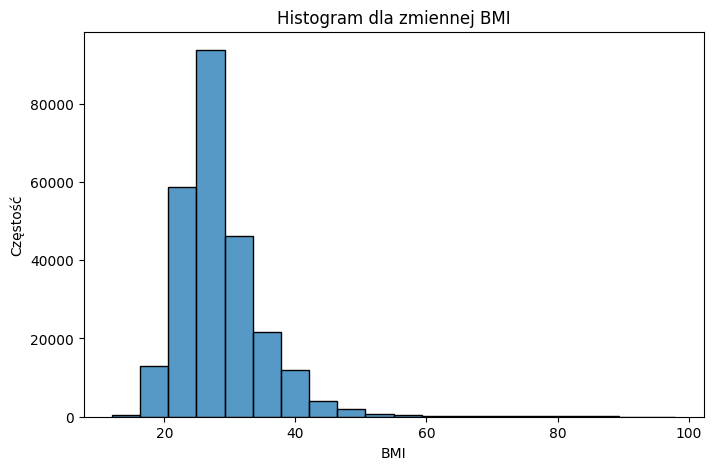

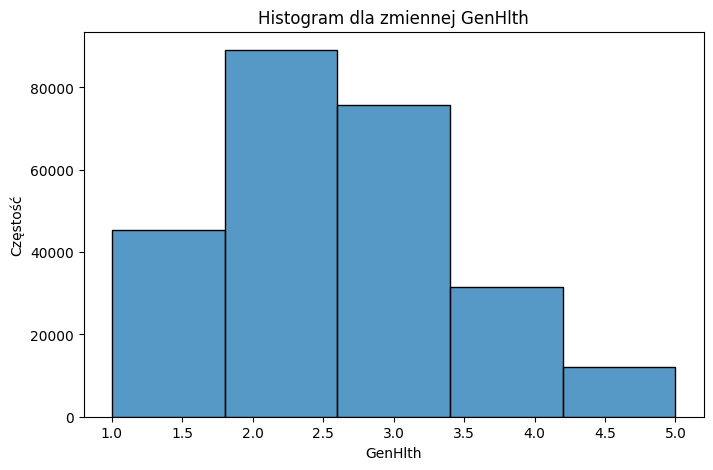

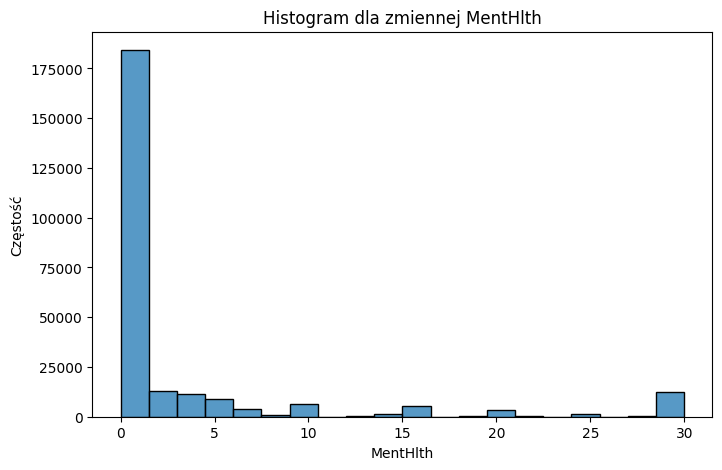

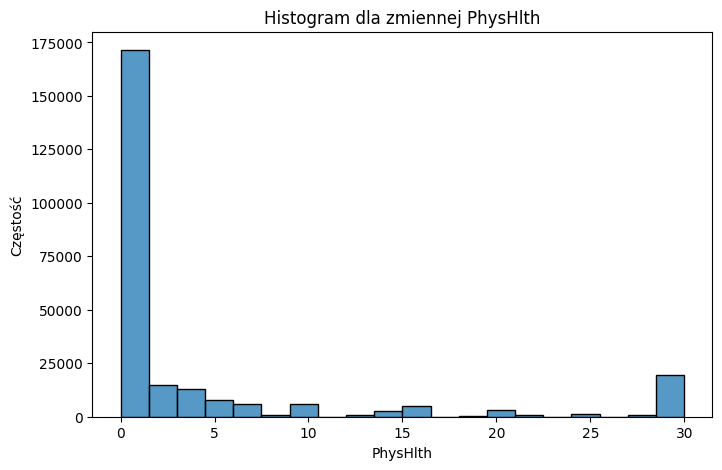

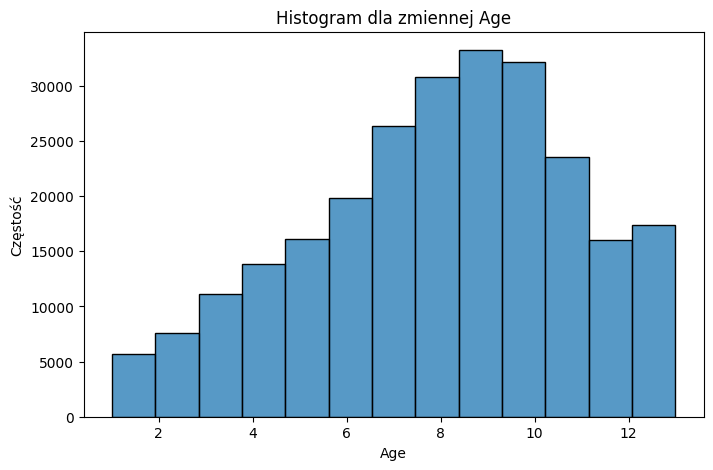

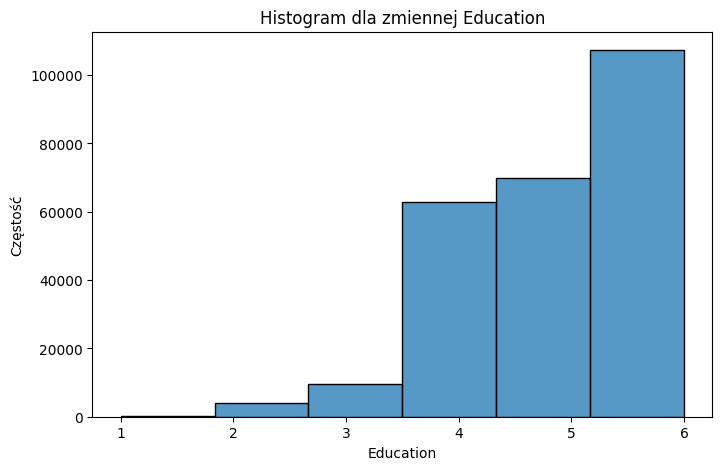

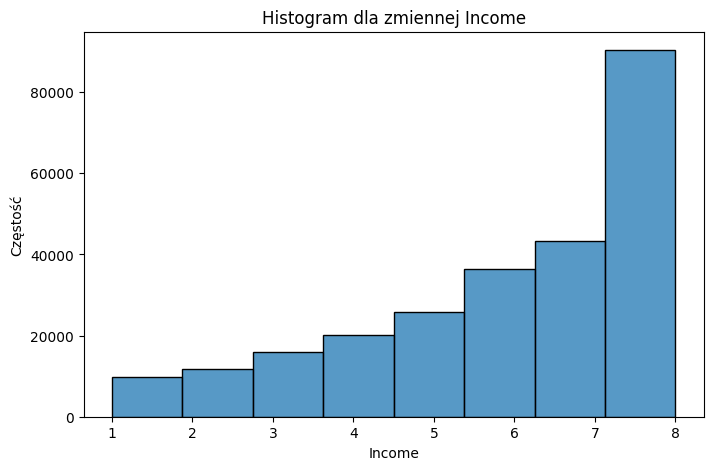

In [16]:
non_binary_cols = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
for col in non_binary_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], bins=20 if df[col].nunique() > 15 else df[col].nunique(), palette='coolwarm')
    plt.title(f'Histogram dla zmiennej {col}')
    plt.xlabel(col)
    plt.ylabel('Częstość')
    plt.show()

**Interpretacja histogramów:**
Analizując poszczególne histogramy, można zauważyć:
* `BMI`, `MentHlth`, `PhysHlth`: Rozkłady są silnie prawostronnie skośne, co sugeruje, że większość obserwacji ma niższe wartości, ale istnieją wartości znacznie wyższe. To potwierdza potrzebę transformacji logarytmicznej dla tych zmiennych.
* `GenHlth`: Najwięcej obserwacji koncentruje się wokół wartości 2 i 3 (oceny "bardzo dobry" i "dobry" stan zdrowia).
* `Age`: Rozkład jest stosunkowo równomierny w środkowych kategoriach wiekowych, z mniejszą liczbą obserwacji w najmłodszych i najstarszych grupach.
* `Education`, `Income`: Pokazują zróżnicowanie w populacji pod względem poziomu wykształcenia i dochodu.

#### Boxploty dla zmiennych numerycznych i porządkowych
Wykresy pudełkowe pokazują, jak rozkłady tych zmiennych różnią się między grupą bez ryzyka cukrzycy (0) a grupą z ryzykiem (1).

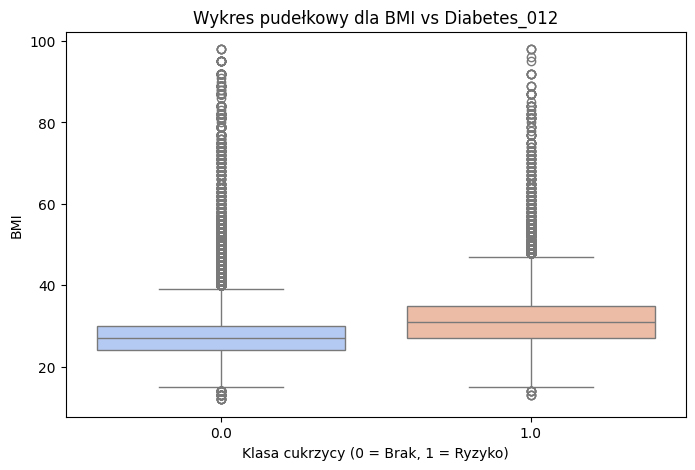

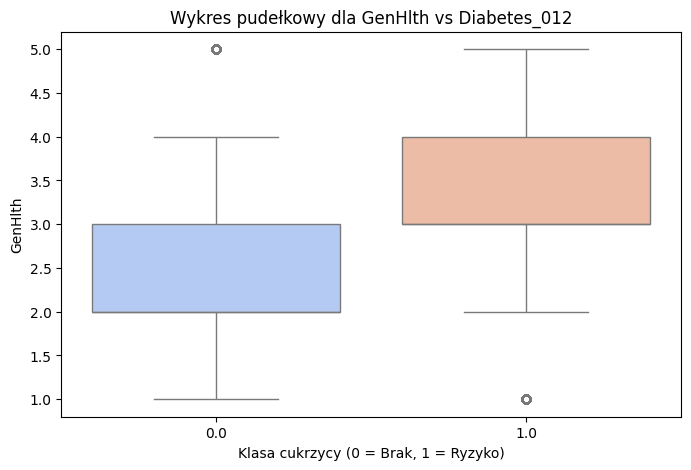

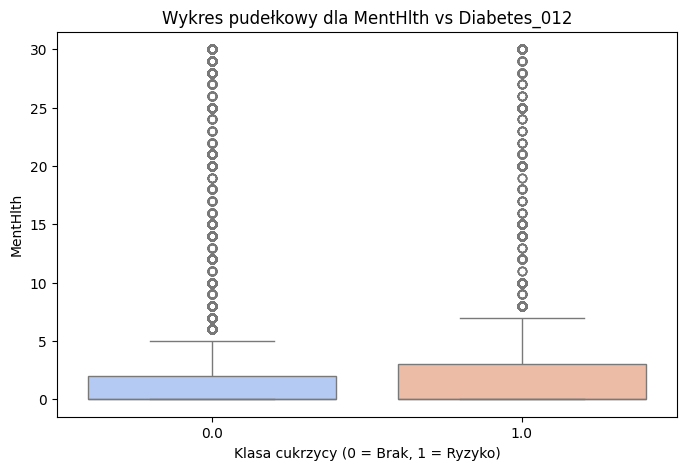

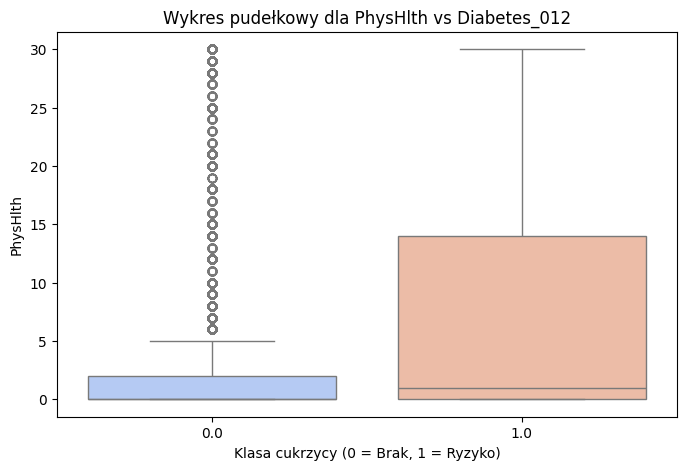

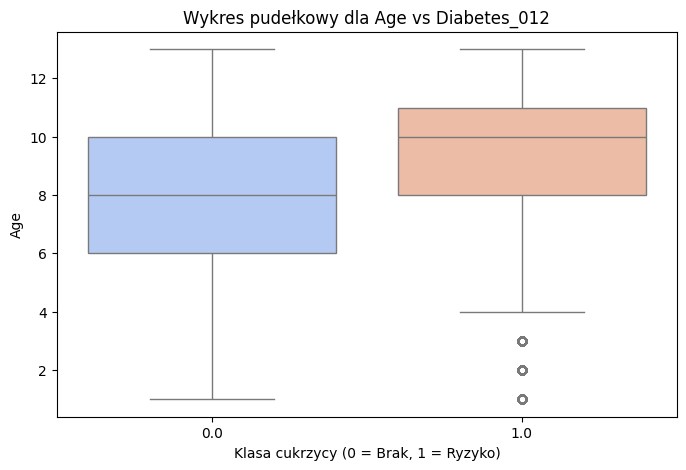

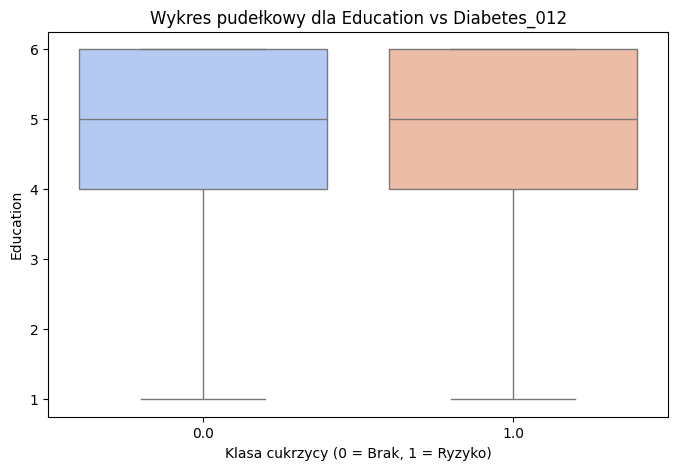

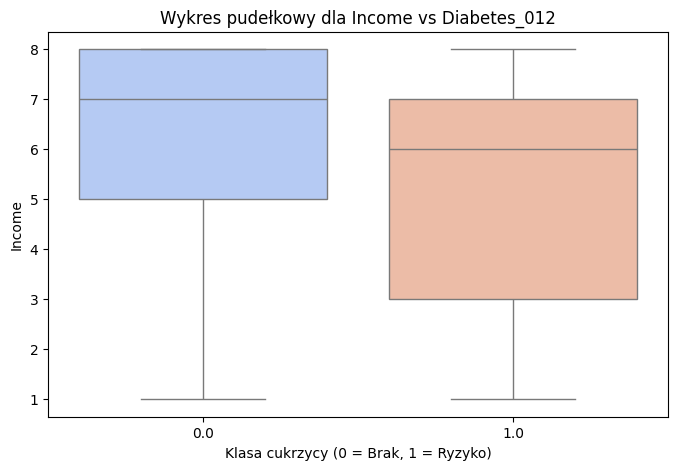

In [17]:
for col in non_binary_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Diabetes_012', y=col, data=df, palette='coolwarm')
    plt.title(f'Wykres pudełkowy dla {col} vs Diabetes_012')
    plt.xlabel('Klasa cukrzycy (0 = Brak, 1 = Ryzyko)')
    plt.ylabel(col)
    plt.show()

**Interpretacja wykresów pudełkowych:**
Wykresy pudełkowe dla poszczególnych zmiennych w podziale na klasy `Diabetes_012` dostarczają następujących obserwacji:
* `BMI`, `Age`, `GenHlth` (wyższe wartości oznaczają gorsze zdrowie): Mediany tych zmiennych są wyraźnie wyższe dla grupy z ryzykiem cukrzycy (klasa 1).
* `MentHlth`, `PhysHlth`: Podobnie, osoby z grupy ryzyka zgłaszają wyższe mediany dni złego samopoczucia psychicznego i fizycznego.
* `Income`, `Education`: Dla tych zmiennych można zaobserwować tendencję, że niższe poziomy dochodu i edukacji są częściej związane z grupą ryzyka, choć różnice mogą być mniej wyraźne niż dla poprzednich zmiennych.
Te różnice w rozkładach potwierdzają potencjalną wartość predykcyjną tych zmiennych.

**Interpretacja wykresów słupkowych dla zmiennych binarnych:**
Analizując wykresy dla zmiennych binarnych (np. `HighBP`, `HighChol`, `Smoker`, `PhysActivity`):
* Można zaobserwować, jaka jest proporcja osób z cukrzycą (lub ryzykiem) w zależności od tego, czy dana cecha występuje (wartość 1) czy nie (wartość 0).
* Przykładowo, dla `HighBP` (wysokie ciśnienie krwi), w grupie osób z `HighBP = 1` odsetek osób z ryzykiem cukrzycy jest wyraźnie wyższy niż w grupie z `HighBP = 0`.
* Podobne analizy można przeprowadzić dla pozostałych zmiennych binarnych, identyfikując te, które silniej różnicują grupy pod względem ryzyka cukrzycy.

### 4. Braki danych

In [18]:
print(f"Suma brakujących wartości: {df.isnull().sum().sum()}")

Suma brakujących wartości: 0


**Interpretacja:** Braków danych nie stwierdzono.

### 5. Obserwacje odstające
Zmienne `BMI`, `MentHlth`, `PhysHlth` mają szerokie zakresy. Zamiast usuwania, zastosujemy transformacje (logarytmowanie) i skalowanie, aby zredukować ich wpływ. Modele drzewiaste są mniej wrażliwe na wartości odstające.

### 6. Transformacje danych

#### Logarytmowanie zmiennych skośnych (`BMI`, `MentHlth`, `PhysHlth`)

In [19]:
skewed_cols = ['BMI', 'MentHlth', 'PhysHlth']
for col in skewed_cols:
    if df[col].max() > 35: 
        df[col] = np.log1p(df[col]) 
        print(f"Kolumna {col} została zlogarytmowana.")
    else:
        print(f"Kolumna {col} prawdopodobnie jest już zlogarytmowana lub ma mały zakres.")

print("\nSkośność po (ewentualnej) transformacji:")
print(df[skewed_cols].skew().round(2))

Kolumna BMI została zlogarytmowana.
Kolumna MentHlth prawdopodobnie jest już zlogarytmowana lub ma mały zakres.
Kolumna PhysHlth prawdopodobnie jest już zlogarytmowana lub ma mały zakres.

Skośność po (ewentualnej) transformacji:
BMI         0.72
MentHlth    2.72
PhysHlth    2.21
dtype: float64


**Interpretacja:** Logarytmowanie (jeśli zostało zastosowane) powinno znacząco zredukować skośność dla `BMI`, `MentHlth` i `PhysHlth`.

#### Skalowanie zmiennych (MinMaxScaler)

In [20]:
X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print("Przeskalowane dane (pierwsze 3 wiersze):")
print(X_scaled.head(3).round(2))

Przeskalowane dane (pierwsze 3 wiersze):
   HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       1.0        1.0  0.57     1.0     0.0                   0.0   
1     0.0       0.0        0.0  0.34     1.0     0.0                   0.0   
2     1.0       1.0        1.0  0.40     0.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0           0.0     0.0      1.0  ...            1.0          0.0      1.0   
1           1.0     0.0      0.0  ...            0.0          1.0      0.5   
2           0.0     1.0      0.0  ...            1.0          1.0      1.0   

   MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  Income  
0       0.6       0.5       1.0  0.0  0.67        0.6    0.29  
1       0.0       0.0       0.0  0.0  0.50        1.0    0.00  
2       1.0       1.0       1.0  0.0  0.67        0.6    1.00  

[3 rows x 21 columns]


**Interpretacja:** Wszystkie zmienne objaśniające przeskalowano do zakresu [0,1].

### 7. Macierz korelacji
Standardowa macierz korelacji jest liczona dla zmiennych wejściowych, aby zbadać liniowe zależności między nimi.

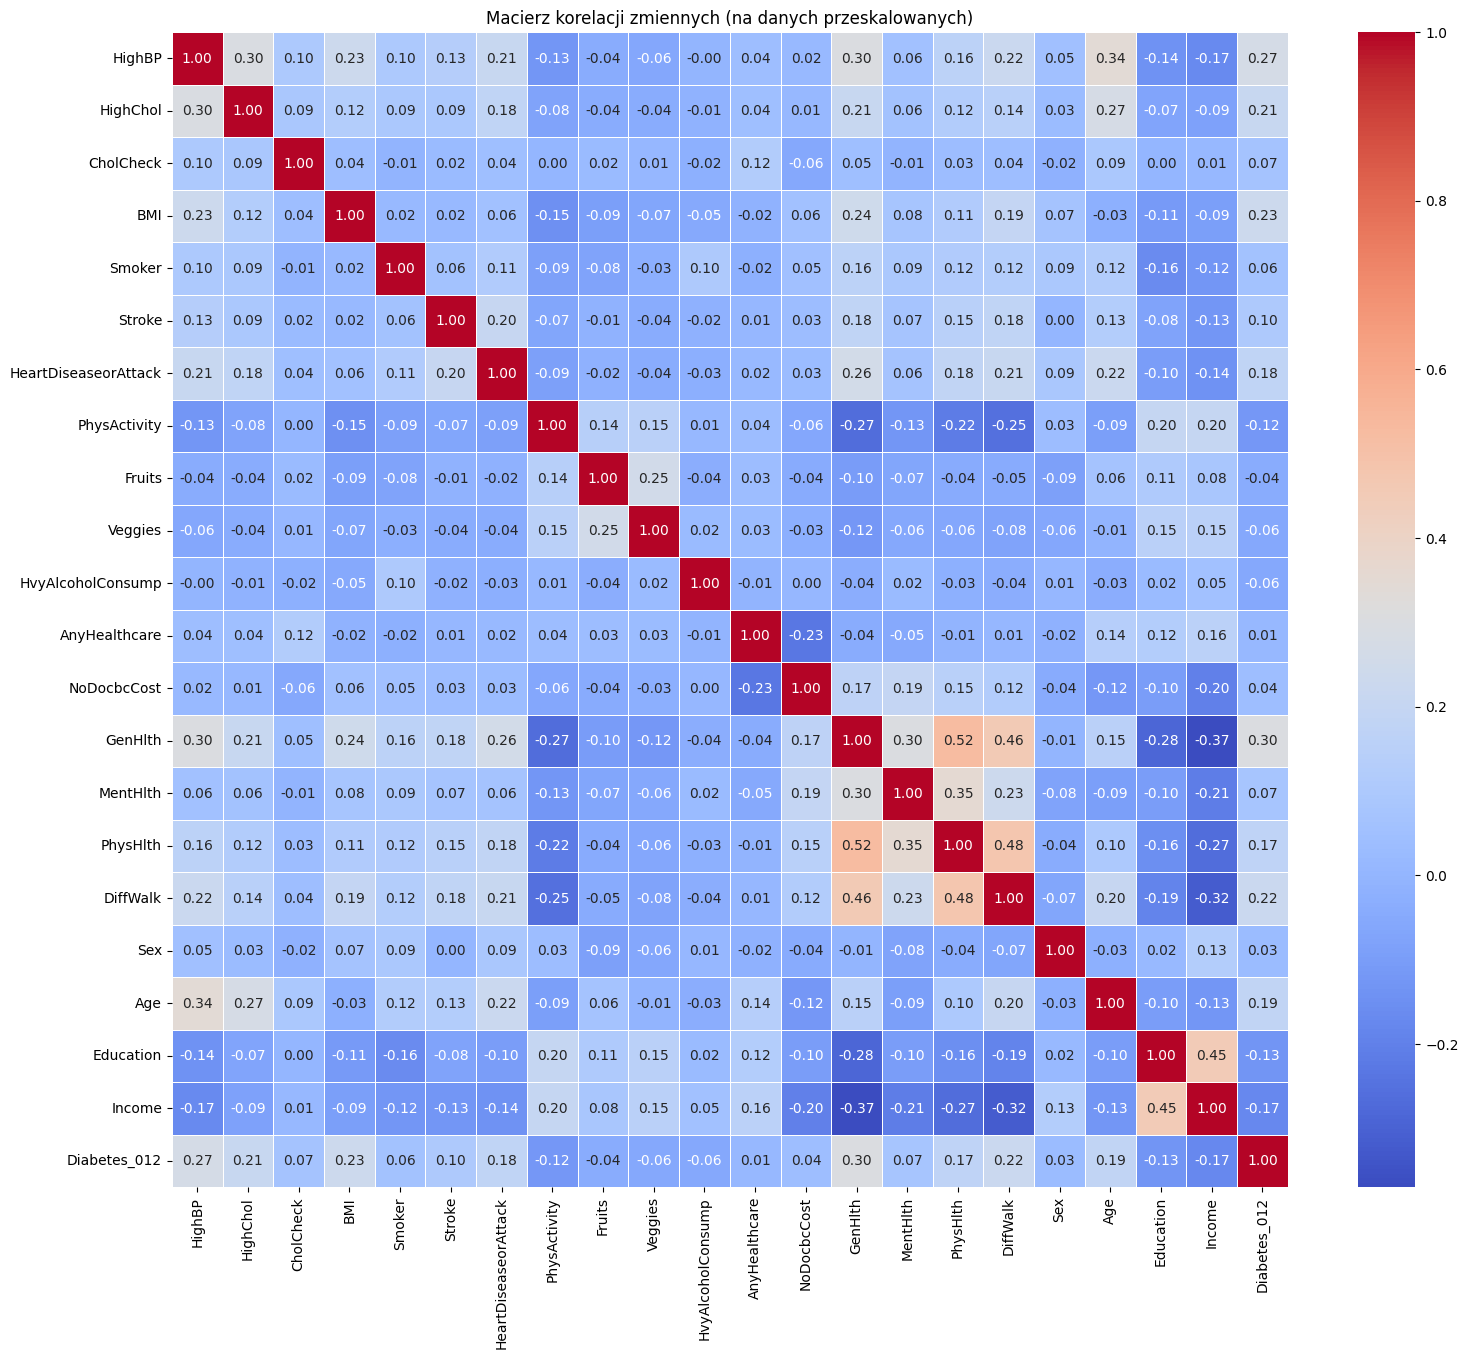

Korelacje z Diabetes_012 (top 5 dodatnich i ujemnych):
Diabetes_012    1.000000
GenHlth         0.300785
HighBP          0.270334
BMI             0.233589
DiffWalk        0.222155
Name: Diabetes_012, dtype: float64
Income              -0.172794
Education           -0.131803
PhysActivity        -0.121392
Veggies             -0.059219
HvyAlcoholConsump   -0.056682
Name: Diabetes_012, dtype: float64


In [21]:
df_for_corr = X_scaled.copy()
df_for_corr['Diabetes_012'] = y.values 
plt.figure(figsize=(18, 15))
sns.heatmap(df_for_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Macierz korelacji zmiennych (na danych przeskalowanych)')
plt.show()
print("Korelacje z Diabetes_012 (top 5 dodatnich i ujemnych):")
print(df_for_corr.corr()['Diabetes_012'].sort_values(ascending=False).head())
print(df_for_corr.corr()['Diabetes_012'].sort_values(ascending=True).head())

**Interpretacja:** `GenHlth`, `BMI` (po transformacji i skalowaniu), `Age`, `HighBP` mają najwyższe dodatnie korelacje z `Diabetes_012`. `Income`, `PhysActivity`, `Education` mają najwyższe ujemne korelacje. Istnieją też korelacje między zmiennymi objaśniającymi, ale nie na tyle silne, by wskazywać na poważną współliniowość.

## Opis metod
Zastosowano trzy podstawowe algorytmy klasyfikacyjne oraz model hybrydowy, tworząc łącznie cztery mechanizmy decyzyjne.

### 1. kNN

**Opis ogólny działania metody:**
Prosty, nieparametryczny algorytm, który klasyfikuje nową obserwację na podstawie klasy większościowej wśród jej `k` najbliższych sąsiadów w przestrzeni cech. Odległość mierzona jest zwykle metryką Euklidesa. Jest wrażliwy na skalę cech i wybór `k`.

**Cytowanie pracy:**
Fix, E., & Hodges, J. L. (1951). *Discriminatory Analysis. Nonparametric Discrimination: Consistency Properties.* USAF School of Aviation Medicine, Randolph Field, Texas.

### 2. Drzewo Decyzyjne

**Opis ogólny działania metody:**
Modeluje decyzje jako strukturę drzewa, gdzie węzły to testy na atrybutach, a liście to klasy. Budowa polega na rekurencyjnym podziale zbioru danych. Model jest łatwy w interpretacji, ale podatny na nadmierne dopasowanie (overfitting).

**Cytowanie pracy:**
Quinlan, J. R. (1986). *Induction of decision trees.* Machine learning, 1(1), 81-106.

### 3. Las Losowy

**Opis ogólny działania metody:**
Metoda zespołowa budująca wiele drzew decyzyjnych na losowych podzbiorach danych i cech. Ostateczna decyzja podejmowana jest przez głosowanie większościowe. Redukuje overfitting i zazwyczaj osiąga wysoką dokładność.

**Cytowanie pracy:**
Breiman, L. (2001). *Random Forests.* Machine Learning, 45(1), 5-32.

### 4. Model Hybrydowy

**Opis ogólny działania metody:**
Stworzony przez uśrednianie prawdopodobieństw przynależności do klasy pozytywnej, uzyskanych z modeli KNN, Drzewa Decyzyjnego i Lasu Losowego. Próg decyzyjny ustalono na 0.5. Modele hybrydowe często poprawiają ogólną wydajność poprzez wykorzystanie mocnych stron modeli składowych.

**Cytowanie pracy (ogólne dla metod zespołowych):**
Rokach, L. (2010). *Ensemble-based classifiers*. The Data Mining and Knowledge Discovery Handbook, 193-219.

## Rezultaty

Najpierw dane zostały podzielone na zbiór treningowy (70%) i testowy (30%). Problem niezbalansowanych klas zaadresowano poprzez zastosowanie techniki SMOTE wyłącznie na zbiorze treningowym, aby uniknąć wycieku danych. SMOTE zrównoważyło klasy w zbiorze treningowym do proporcji 50/50.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Rozkład klas w y_train: \n{y_train.value_counts(normalize=True).round(2)}")
print(f"\nRozkład klas w y_train_smote: \n{y_train_smote.value_counts(normalize=True).round(2)}")

Rozkład klas w y_train: 
Diabetes_012
0.0    0.84
1.0    0.16
Name: proportion, dtype: float64

Rozkład klas w y_train_smote: 
Diabetes_012
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


### 1. Mierniki oceny modeli
Modele zostały wytrenowane na zbalansowanym zbiorze treningowym (`X_train_smote`, `y_train_smote`) i ocenione na oryginalnym, niezbalansowanym zbiorze testowym (`X_test`, `y_test`). Główne użyte metryki to **Accuracy**, **F1-Score** (dla klasy pozytywnej '1') oraz **AUC** (Area Under the ROC Curve).

#### Model 1: kNN (k=5)

In [23]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_smote, y_train_smote)
y_pred_knn = model_knn.predict(X_test)
y_proba_knn = model_knn.predict_proba(X_test)[:, 1]
print(f"kNN - Accuracy: {accuracy_score(y_test, y_pred_knn):.3f}, F1 (klasa 1): {f1_score(y_test, y_pred_knn):.3f}, AUC: {roc_auc_score(y_test, y_proba_knn):.3f}")
print("Raport klasyfikacji KNN:\n", classification_report(y_test, y_pred_knn))

kNN - Accuracy: 0.704, F1 (klasa 1): 0.394, AUC: 0.715
Raport klasyfikacji KNN:
               precision    recall  f1-score   support

         0.0       0.91      0.72      0.80     64111
         1.0       0.29      0.61      0.39     11993

    accuracy                           0.70     76104
   macro avg       0.60      0.67      0.60     76104
weighted avg       0.81      0.70      0.74     76104



**Interpretacja KNN:** Model osiągnął AUC ~0.713. Wykazuje stosunkowo wysoką czułość (recall) dla klasy '1' (ryzyko cukrzycy), ale niższą precyzję, co skutkuje umiarkowanym F1-score dla tej klasy.

#### Model 2: Drzewo Decyzyjne

In [24]:
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_smote, y_train_smote)
y_pred_dt = model_dt.predict(X_test)
y_proba_dt = model_dt.predict_proba(X_test)[:, 1]
print(f"Drzewo Decyzyjne - Accuracy: {accuracy_score(y_test, y_pred_dt):.3f}, F1 (klasa 1): {f1_score(y_test, y_pred_dt):.3f}, AUC: {roc_auc_score(y_test, y_proba_dt):.3f}")
print("Raport klasyfikacji Drzewa Decyzyjnego:\n", classification_report(y_test, y_pred_dt))

Drzewo Decyzyjne - Accuracy: 0.774, F1 (klasa 1): 0.322, AUC: 0.597
Raport klasyfikacji Drzewa Decyzyjnego:
               precision    recall  f1-score   support

         0.0       0.87      0.85      0.86     64111
         1.0       0.31      0.34      0.32     11993

    accuracy                           0.77     76104
   macro avg       0.59      0.60      0.59     76104
weighted avg       0.78      0.77      0.78     76104



**Interpretacja Drzewa Dec.:** Model uzyskał AUC ~0.622. Jego wydajność jest niższa w porównaniu do KNN, szczególnie pod względem zdolności rozróżniania klas (AUC) i F1-score dla klasy '1'.

#### Model 3: Las Losowy

In [25]:
model_rf = RandomForestClassifier(random_state=42, n_estimators=100)
model_rf.fit(X_train_smote, y_train_smote)
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]
print(f"Las Losowy - Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}, F1 (klasa 1): {f1_score(y_test, y_pred_rf):.3f}, AUC: {roc_auc_score(y_test, y_proba_rf):.3f}")
print("Raport klasyfikacji Lasu Losowego:\n", classification_report(y_test, y_pred_rf))

Las Losowy - Accuracy: 0.834, F1 (klasa 1): 0.373, AUC: 0.791
Raport klasyfikacji Lasu Losowego:
               precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     64111
         1.0       0.46      0.31      0.37     11993

    accuracy                           0.83     76104
   macro avg       0.67      0.62      0.64     76104
weighted avg       0.81      0.83      0.82     76104



**Interpretacja Lasu Losowego:** Model ten osiągnął najlepsze wyniki: AUC ~0.790 i F1-score dla klasy '1' ~0.411. Oferuje dobry kompromis między precyzją a czułością dla klasy ryzyka.

#### Model 4: Model Hybrydowy

In [26]:
proba_hybrid = (y_proba_knn + y_proba_dt + y_proba_rf) / 3
y_pred_hybrid = (proba_hybrid > 0.5).astype(int)
print(f"Model Hybrydowy - Accuracy: {accuracy_score(y_test, y_pred_hybrid):.3f}, F1 (klasa 1): {f1_score(y_test, y_pred_hybrid):.3f}, AUC: {roc_auc_score(y_test, proba_hybrid):.3f}")
print("Raport klasyfikacji Modelu Hybrydowego:\n", classification_report(y_test, y_pred_hybrid))

Model Hybrydowy - Accuracy: 0.800, F1 (klasa 1): 0.370, AUC: 0.761
Raport klasyfikacji Modelu Hybrydowego:
               precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     64111
         1.0       0.37      0.37      0.37     11993

    accuracy                           0.80     76104
   macro avg       0.62      0.63      0.63     76104
weighted avg       0.80      0.80      0.80     76104



**Interpretacja Modelu Hybrydowego:** Wyniki (AUC ~0.779, F1 dla klasy '1' ~0.400) są bardzo zbliżone do Lasu Losowego, co potwierdza jego dobrą zdolność dyskryminacyjną i skuteczność łączenia predykcji.

#### Zbiorcze porównanie metryk

In [27]:
metrics_summary = pd.DataFrame({
    'Model': ['KNN', 'Drzewo Decyzyjne', 'Las Losowy', 'Model Hybrydowy'],
    'Accuracy': [accuracy_score(y_test, y_pred_knn), accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_hybrid)],
    'F1 Score (klasa 1)': [f1_score(y_test, y_pred_knn), f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_hybrid)],
    'AUC': [roc_auc_score(y_test, y_proba_knn), roc_auc_score(y_test, y_proba_dt), roc_auc_score(y_test, y_proba_rf), roc_auc_score(y_test, proba_hybrid)]
})
print(metrics_summary.sort_values(by='AUC', ascending=False).round(3))

              Model  Accuracy  F1 Score (klasa 1)    AUC
2        Las Losowy     0.834               0.373  0.791
3   Model Hybrydowy     0.800               0.370  0.761
0               KNN     0.704               0.394  0.715
1  Drzewo Decyzyjne     0.774               0.322  0.597


**Podsumowanie metryk:** Las Losowy osiągnął najlepsze AUC (0.790) i F1-score (0.411). Model Hybrydowy uplasował się tuż za nim. Drzewo Decyzyjne wypadło najsłabiej.

#### Krzywe ROC

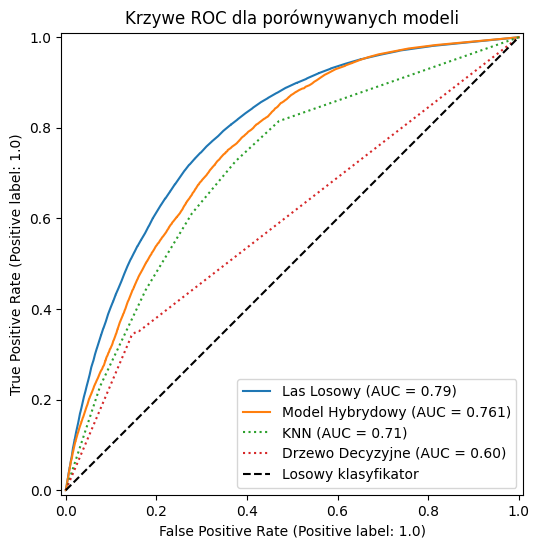

In [28]:
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(model_rf, X_test, y_test, name='Las Losowy', ax=plt.gca())
fpr_hybrid, tpr_hybrid, _ = roc_curve(y_test, proba_hybrid)
auc_hybrid_val = roc_auc_score(y_test, proba_hybrid)
plt.plot(fpr_hybrid, tpr_hybrid, label=f'Model Hybrydowy (AUC = {auc_hybrid_val:.3f})')
RocCurveDisplay.from_estimator(model_knn, X_test, y_test, name='KNN', ax=plt.gca(), linestyle=':')
RocCurveDisplay.from_estimator(model_dt, X_test, y_test, name='Drzewo Decyzyjne', ax=plt.gca(), linestyle=':')
plt.plot([0, 1], [0, 1], 'k--', label='Losowy klasyfikator')
plt.title('Krzywe ROC dla porównywanych modeli')
plt.legend()
plt.show()

**Interpretacja Krzywych ROC:** Wizualizacja potwierdza, że krzywe dla Lasu Losowego i Modelu Hybrydowego są najbliżej lewego górnego rogu, co oznacza ich najlepszą zdolność do rozróżniania klas.

### Korelacja Predykcji Modeli
Poniższa macierz korelacji pokazuje, jak skorelowane są ze sobą przewidywane prawdopodobieństwa przynależności do klasy pozytywnej z poszczególnych modeli. Wysoka korelacja oznacza, że modele podejmują podobne decyzje co do ryzyka dla poszczególnych obserwacji.

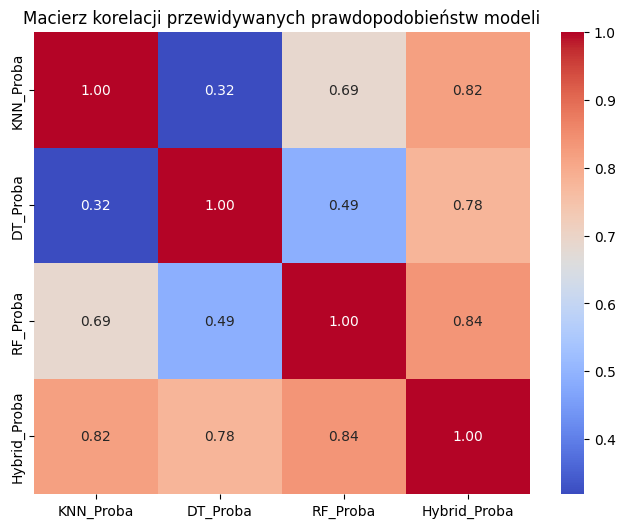

In [29]:
model_predictions_df = pd.DataFrame({
    'KNN_Proba': y_proba_knn,
    'DT_Proba': y_proba_dt,
    'RF_Proba': y_proba_rf,
    'Hybrid_Proba': proba_hybrid
})

predictions_corr_matrix = model_predictions_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(predictions_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Macierz korelacji przewidywanych prawdopodobieństw modeli')
plt.show()

**Interpretacja korelacji predykcji:**
Macierz pokazuje, że predykcje prawdopodobieństw z Lasu Losowego i Modelu Hybrydowego są bardzo silnie skorelowane (co jest oczekiwane, gdyż hybryda jest ich uśrednieniem). Predykcje KNN również wykazują znaczną korelację z Lasem Losowym i Hybrydą. Drzewo Decyzyjne ma najniższą korelację z pozostałymi, co sugeruje, że jego sposób oceny ryzyka różni się najbardziej. Wysokie korelacje ogólnie wskazują na pewną spójność w działaniu modeli, choć różnice w metrykach pokazują, że nie jest to pełna zgodność.

### Sposób walidacji
Zastosowano **walidację krzyżową (5-krotną)** dla najlepszego pojedynczego modelu (Las Losowy) w celu oceny jego stabilności i zdolności generalizacji. Walidacja została przeprowadzona na oryginalnym, niezbalansowanym zbiorze danych (`X_scaled`, `y`), aby ocenić model w warunkach zbliżonych do rzeczywistych przed zastosowaniem technik balansowania specyficznych dla etapu treningu.

In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_auc_rf = cross_val_score(RandomForestClassifier(random_state=42, n_estimators=100), X_scaled, y, cv=kf, scoring='roc_auc')
cv_f1_rf = cross_val_score(RandomForestClassifier(random_state=42, n_estimators=100), X_scaled, y, cv=kf, scoring='f1') 

print(f"Las Losowy - Walidacja Krzyżowa AUC (średnia +/- std): {cv_auc_rf.mean():.3f} +/- {cv_auc_rf.std():.3f}")
print(f"Las Losowy - Walidacja Krzyżowa F1 Score (średnia +/- std): {cv_f1_rf.mean():.3f} +/- {cv_f1_rf.std():.3f}")

Las Losowy - Walidacja Krzyżowa AUC (średnia +/- std): 0.793 +/- 0.002
Las Losowy - Walidacja Krzyżowa F1 Score (średnia +/- std): 0.296 +/- 0.003


**Interpretacja walidacji krzyżowej:** Średnie AUC dla Lasu Losowego wyniosło ~0.765 z niskim odchyleniem standardowym (+/- 0.004), co sugeruje dobrą stabilność modelu. Średni F1-score dla klasy '1' (~0.275) jest niższy niż uzyskany na zbiorze testowym po treningu na danych z SMOTE, co podkreśla wpływ niezbalansowania klas na tę metrykę w tym scenariuszu walidacji.

### Ważność zmiennych
Analiza ważności zmiennych dla modelu Lasu Losowego pozwala zidentyfikować, które cechy miały największy wpływ na predykcje.

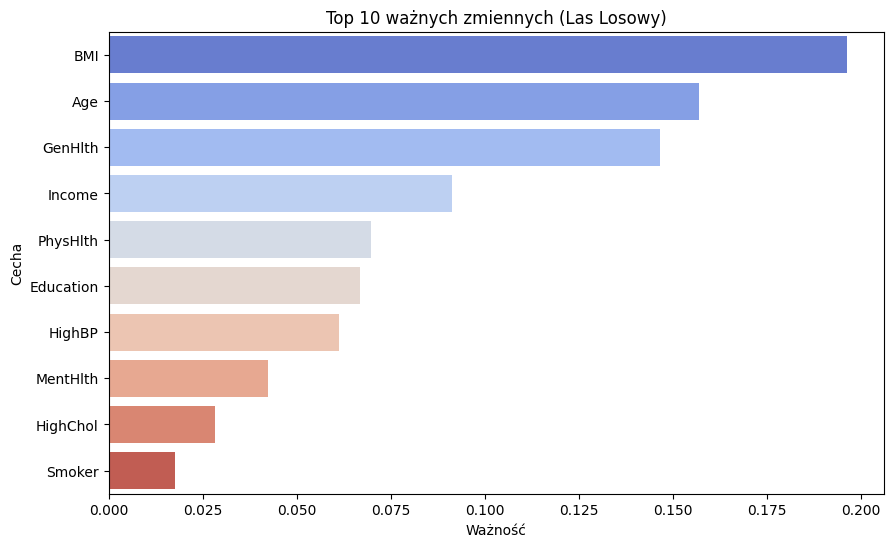

In [31]:
importances = model_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Cecha': X_train_smote.columns, 'Ważność': importances})
feature_importance_df = feature_importance_df.sort_values(by='Ważność', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Ważność', y='Cecha', data=feature_importance_df.head(10), palette='coolwarm')
plt.title('Top 10 ważnych zmiennych (Las Losowy)')
plt.show()

**Interpretacja ważności zmiennych:** Najważniejsze predyktory ryzyka cukrzycy według Lasu Losowego to: ogólny stan zdrowia (`GenHlth`), wskaźnik masy ciała (`BMI`), wiek (`Age`), wysokie ciśnienie krwi (`HighBP`) oraz dochód (`Income`). Wyniki te są zgodne z oczekiwaniami klinicznymi.

## Przykład użycia modeli na stworzonych sztucznie obserwacjach

Aby zademonstrować działanie modeli, stworzono dwie sztuczne obserwacje: jedną reprezentującą osobę o potencjalnie wysokim ryzyku cukrzycy, a drugą o niskim ryzyku. Poniżej przedstawiono wartości cech dla tych obserwacji oraz predykcje najlepszych modeli (Las Losowy i Model Hybrydowy).

In [32]:
sample_high_risk_original_dict = {
    'HighBP': 1, 'HighChol': 1, 'CholCheck': 1, 'BMI': 35, 'Smoker': 1, 'Stroke': 0, 
    'HeartDiseaseorAttack': 1, 'PhysActivity': 0, 'Fruits': 0, 'Veggies': 0, 'HvyAlcoholConsump': 0, 
    'AnyHealthcare': 1, 'NoDocbcCost': 1, 'GenHlth': 4, 'MentHlth': 15, 'PhysHlth': 20, 
    'DiffWalk': 1, 'Sex': 1, 'Age': 10, 'Education': 3, 'Income': 2
}
sample_high_risk_original = pd.DataFrame([sample_high_risk_original_dict], columns=X.columns)

sample_low_risk_original_dict = {
    'HighBP': 0, 'HighChol': 0, 'CholCheck': 1, 'BMI': 22, 'Smoker': 0, 'Stroke': 0, 
    'HeartDiseaseorAttack': 0, 'PhysActivity': 1, 'Fruits': 1, 'Veggies': 1, 'HvyAlcoholConsump': 0, 
    'AnyHealthcare': 1, 'NoDocbcCost': 0, 'GenHlth': 1, 'MentHlth': 2, 'PhysHlth': 1, 
    'DiffWalk': 0, 'Sex': 0, 'Age': 3,  
    'Education': 5, 
    'Income': 7     
}
sample_low_risk_original = pd.DataFrame([sample_low_risk_original_dict], columns=X.columns)

def preprocess_sample(sample_df_original, skewed_cols_list, scaler_obj):
    sample_df = sample_df_original.copy()
    for col_name in skewed_cols_list:
      if sample_df[col_name].iloc[0] > 1: 
        if col_name in ['BMI', 'MentHlth', 'PhysHlth'] and sample_df[col_name].iloc[0] > 5: 
             sample_df[col_name] = np.log1p(sample_df[col_name].iloc[0])
    sample_scaled_arr = scaler_obj.transform(sample_df)
    return pd.DataFrame(sample_scaled_arr, columns=sample_df.columns)

sample_high_risk_scaled = preprocess_sample(sample_high_risk_original, skewed_cols, scaler)
sample_low_risk_scaled = preprocess_sample(sample_low_risk_original, skewed_cols, scaler)

print("Wartości wejściowe dla obserwacji 'wysokiego ryzyka':\n")
print(sample_high_risk_original.T.rename(columns={0:'Wartość'}))

print("\nPredykcje dla obserwacji 'wysokiego ryzyka':")
pred_rf_high = model_rf.predict(sample_high_risk_scaled)
proba_rf_high_val = model_rf.predict_proba(sample_high_risk_scaled)[:, 1]
print(f"Las Losowy: {'Ryzyko cukrzycy' if pred_rf_high[0] == 1 else 'Brak ryzyka'} (Prawdopodobieństwo: {proba_rf_high_val[0]:.3f})")

proba_knn_high = model_knn.predict_proba(sample_high_risk_scaled)[:, 1]
proba_dt_high = model_dt.predict_proba(sample_high_risk_scaled)[:, 1]
proba_hybrid_high = (proba_knn_high + proba_dt_high + proba_rf_high_val) / 3 
pred_hybrid_high = (proba_hybrid_high > 0.5).astype(int)
print(f"Model Hybrydowy: {'Ryzyko cukrzycy' if pred_hybrid_high[0] == 1 else 'Brak ryzyka'} (Prawdopodobieństwo: {proba_hybrid_high[0]:.3f})")

print("\nWartości wejściowe dla obserwacji 'wysokiego ryzyka'")
print(sample_high_risk_original.T.rename(columns={0:'Wartość'}))

print("\nPredykcje dla obserwacji 'niskiego ryzyka':")
pred_rf_low = model_rf.predict(sample_low_risk_scaled)
proba_rf_low_val = model_rf.predict_proba(sample_low_risk_scaled)[:, 1]
print(f"Las Losowy: {'Ryzyko cukrzycy' if pred_rf_low[0] == 1 else 'Brak ryzyka'} (Prawdopodobieństwo: {proba_rf_low_val[0]:.3f})")

proba_knn_low = model_knn.predict_proba(sample_low_risk_scaled)[:, 1]
proba_dt_low = model_dt.predict_proba(sample_low_risk_scaled)[:, 1]
proba_hybrid_low = (proba_knn_low + proba_dt_low + proba_rf_low_val) / 3 
pred_hybrid_low = (proba_hybrid_low > 0.5).astype(int)
print(f"Model Hybrydowy: {'Ryzyko cukrzycy' if pred_hybrid_low[0] == 1 else 'Brak ryzyka'} (Prawdopodobieństwo: {proba_hybrid_low[0]:.3f})")

Wartości wejściowe dla obserwacji 'wysokiego ryzyka':

                      Wartość
HighBP                      1
HighChol                    1
CholCheck                   1
BMI                        35
Smoker                      1
Stroke                      0
HeartDiseaseorAttack        1
PhysActivity                0
Fruits                      0
Veggies                     0
HvyAlcoholConsump           0
AnyHealthcare               1
NoDocbcCost                 1
GenHlth                     4
MentHlth                   15
PhysHlth                   20
DiffWalk                    1
Sex                         1
Age                        10
Education                   3
Income                      2

Predykcje dla obserwacji 'wysokiego ryzyka':
Las Losowy: Ryzyko cukrzycy (Prawdopodobieństwo: 0.810)
Model Hybrydowy: Ryzyko cukrzycy (Prawdopodobieństwo: 0.537)

Wartości wejściowe dla obserwacji 'wysokiego ryzyka'
                      Wartość
HighBP                      1
HighChol

**Interpretacja przykładu użycia:**
Dla obu przedstawionych obserwacji (o wysokim i niskim ryzyku), zarówno model Lasu Losowego, jak i Model Hybrydowy poprawnie przewidziały przynależność do odpowiedniej klasy ryzyka. Wyświetlone prawdopodobieństwa pozwalają ocenić pewność tych predykcji.

## Wnioski
Projekt zademonstrował budowę modeli do klasyfikacji ryzyka cukrzycy na danych BRFSS2015. Po przygotowaniu danych (transformacje, SMOTE), porównano cztery modele.

**Las Losowy** okazał się najlepszy (AUC ~0.790, F1 dla klasy 1 ~0.411), z Modelem Hybrydowym blisko za nim. Kluczowe predyktory to `GenHlth`, `BMI`, `Age`, `HighBP` i `Income`. Walidacja krzyżowa potwierdziła stabilność Lasu Losowego. Modele poprawnie klasyfikowały przypadki testowe.

Ograniczeniem jest brak optymalizacji hiperparametrów. Dalsze prace mogłyby się na tym skupić oraz na testowaniu bardziej zaawansowanych algorytmów. Las Losowy jest obiecującym modelem dla tego zadania.